# Project Description
### Scenario
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

### Metadata
* **city:** city this user signed up in
* **phone:** primary device for this user
* **signup_date:** date of account registration; in the form ‘YYYYMMDD’
* **last_trip_date:** the last time this user completed a trip; in the form ‘YYYYMMDD’
* **avg_dist:** the average distance in miles per trip taken in the first 30 days after signup
* **avg_rating_by_driver:** the rider’s average rating over all of their trips
* **avg_rating_of_driver:** the rider’s average rating of their drivers over all of their trips
* **surge_pct:** the percent of trips taken with surge multiplier > 1
* **avg_surge:** The average surge multiplier over all of this user’s trips
* **trips_in_first_30_days:** the number of trips this user took in the first 30 days after signing up
* **ultimate_black_user:** TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* **weekday_pct:** the percent of the user’s trips occurring during a weekday

# Load Packages

In [1]:
import json
from mizani.formatters import * # this has various scales
import numpy as np
import pandas as pd
from plotnine import *
import plotnine
import plydata.cat_tools as cat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings

plotnine.options.figure_size = (20, 10)
warnings.filterwarnings("ignore")

# Load Data

In [2]:
df = pd.read_json("ultimate_data_challenge.json")
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


# Data Cleaning

* **avg_rating_of_driver:** fill all missing values with its median
* **avg_rating_by_driver:** fill all missing values with its median
* **phone:** drop all rows with missing values. Create dummy variables
* **city:** create dummy variables
* **ultimate_black_user:** convert from logical to numeric to make it easeir to work with
* **sign_up_date:** convert from object to date
* **last_trip_date:** convert from object to date for use in creating output column for whether or not a user was retained
* **retained:** newly created column, if the user's last trip was within the previous 30 days

In [4]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [5]:
df.phone.value_counts(dropna = False)

iPhone     34582
Android    15022
None         396
Name: phone, dtype: int64

In [6]:
df[["avg_rating_of_driver", "avg_rating_by_driver"]].describe().transpose()[["mean", "50%"]]

,mean,50%
avg_rating_of_driver,4.601559,4.9
avg_rating_by_driver,4.778158,5.0


In [7]:
df = pd.get_dummies(df.drop(df[df.phone.isna() == True].index, axis = 0), columns = ["city", "phone"], drop_first = True).\
assign(signup_date = lambda x: pd.to_datetime(x.signup_date), 
       last_trip_date = lambda x: pd.to_datetime(x.last_trip_date), 
       avg_rating_of_driver = lambda x: x.avg_rating_of_driver.fillna(x.avg_rating_of_driver.median()), 
       avg_rating_by_driver = lambda x: x.avg_rating_by_driver.fillna(x.avg_rating_by_driver.median()),
       ultimate_black_user = lambda x: x.ultimate_black_user.astype(int),
       retention = lambda x: ((x.last_trip_date.max() - x.last_trip_date).dt.days < 30).astype(int))

# Exploratory Data Analysis

Double check the info to make sure everything is set up properly

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  49604 non-null  int64         
 1   signup_date             49604 non-null  datetime64[ns]
 2   avg_rating_of_driver    49604 non-null  float64       
 3   avg_surge               49604 non-null  float64       
 4   last_trip_date          49604 non-null  datetime64[ns]
 5   surge_pct               49604 non-null  float64       
 6   ultimate_black_user     49604 non-null  int32         
 7   weekday_pct             49604 non-null  float64       
 8   avg_dist                49604 non-null  float64       
 9   avg_rating_by_driver    49604 non-null  float64       
 10  city_King's Landing     49604 non-null  uint8         
 11  city_Winterfell         49604 non-null  uint8         
 12  phone_iPhone            49604 non-null  uint8 

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,49604.0,2.277256,3.793300,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,49604.0,4.649770,0.575820,1.0,4.50,4.90,5.00,5.00
avg_surge,49604.0,1.074991,0.222666,1.0,1.00,1.00,1.05,8.00
surge_pct,49604.0,8.875314,19.989018,0.0,0.00,0.00,8.70,100.00
ultimate_black_user,49604.0,0.375212,0.484182,0.0,0.00,0.00,1.00,1.00
weekday_pct,49604.0,60.883832,37.086239,0.0,33.30,66.70,100.00,100.00
avg_dist,49604.0,5.785418,5.669709,0.0,2.42,3.88,6.93,160.96
avg_rating_by_driver,49604.0,4.778748,0.446440,1.0,4.70,5.00,5.00,5.00
city_King's Landing,49604.0,0.202927,0.402183,0.0,0.00,0.00,0.00,1.00
city_Winterfell,49604.0,0.466192,0.498861,0.0,0.00,0.00,1.00,1.00


Nothing looks out of the ordinary in the summary table

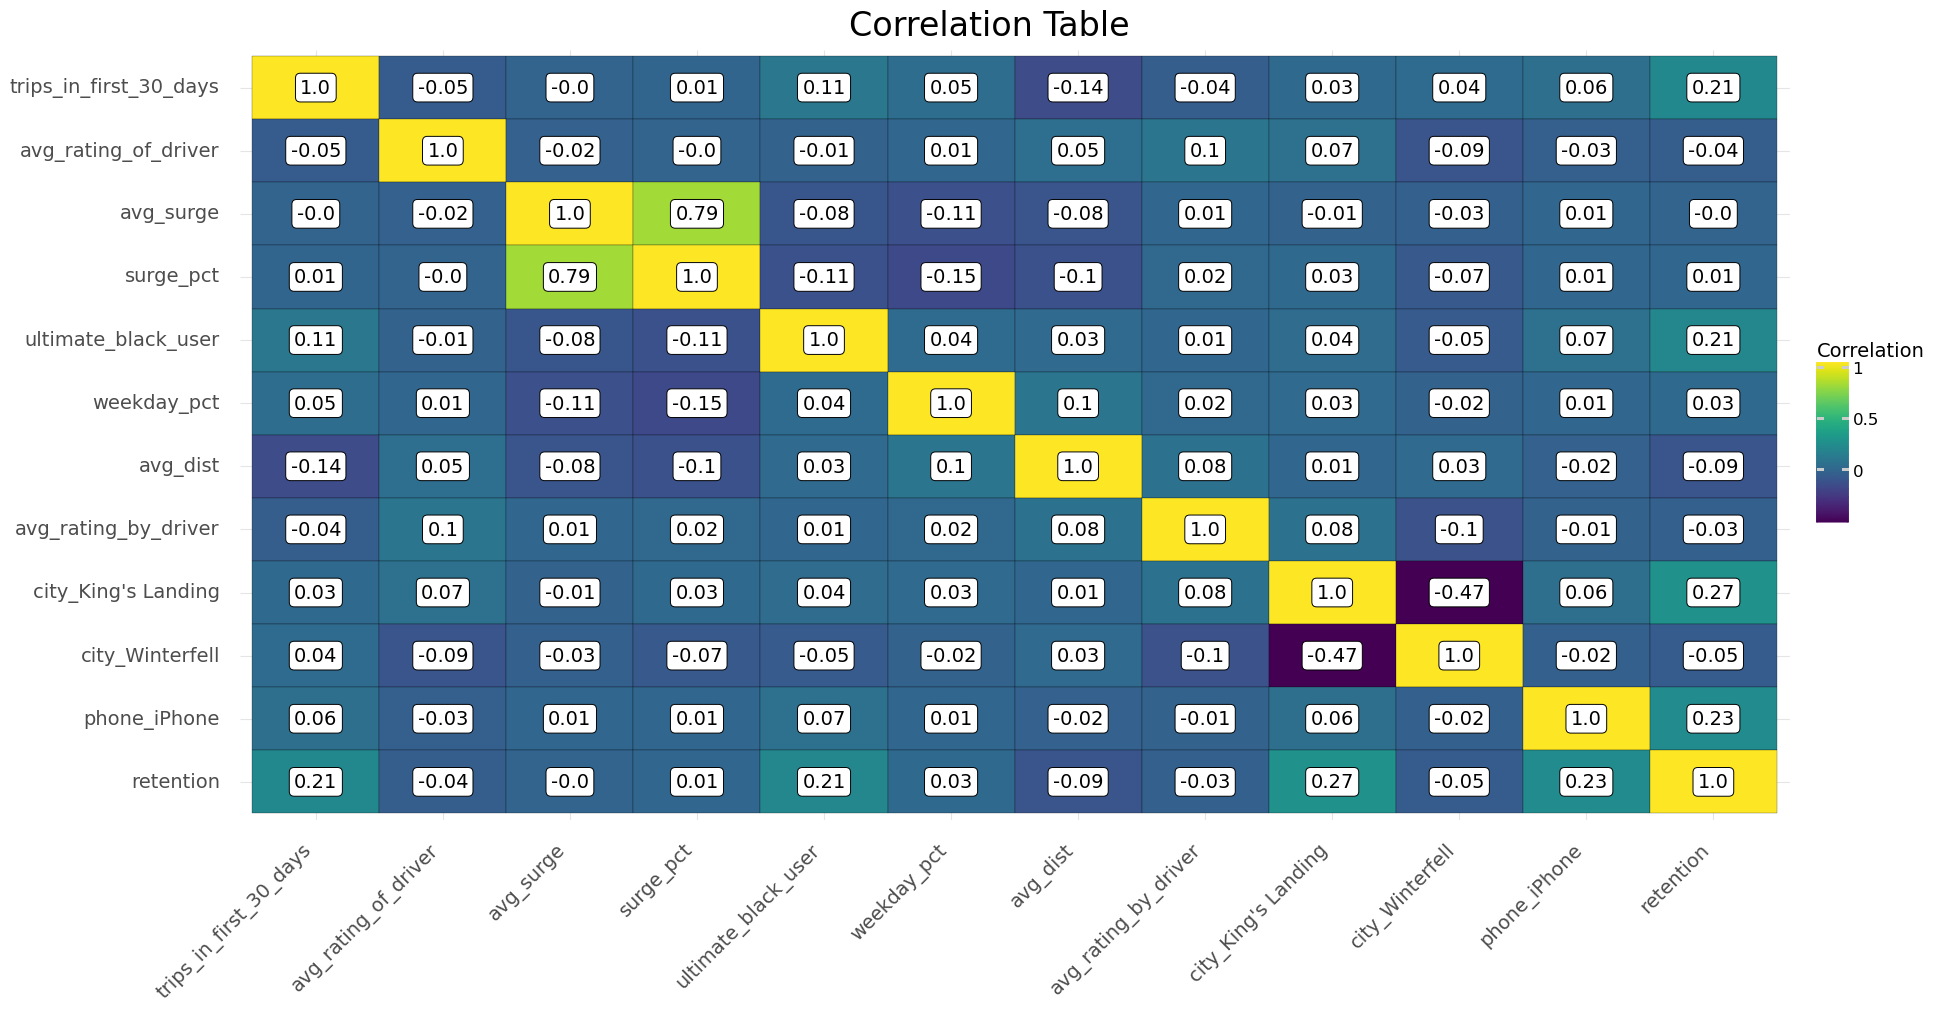

<ggplot: (164176306547)>

In [10]:
df_corr = df.corr().\
melt(ignore_index = False).\
reset_index().\
set_axis(labels = ["var1", "var2", "value"], 
         axis = 1).\
assign(lab_text = lambda x: np.round(x.value, 2)).\
assign(var1 = lambda x: cat.cat_inorder(x.var1),
       var2 = lambda x: cat.cat_rev(cat.cat_inorder(x.var2)))

(ggplot(df_corr, aes(x = "var1", y = "var2", fill = "value", label = "lab_text")) + 
 geom_tile(color = "black") +
 geom_label(fill = "white", size = 14) + 
 labs(title = "Correlation Table", 
     x = "", 
     y = "", 
     fill = "Correlation") + 
 theme_minimal() + 
 theme(axis_text_x = element_text(size = 14, rotation = 45, hjust = 1), 
       axis_text_y = element_text(size = 14), 
       legend_text = element_text(size = 12), 
       legend_title = element_text(size = 14), 
       plot_title = element_text(size = 24)))

In [11]:
df.corr()[["retention"]].\
assign(ish = lambda x: x.retention.abs()).\
sort_values("ish", ascending = False).\
drop("retention", axis = 0).\
retention

city_King's Landing       0.268372
phone_iPhone              0.233427
trips_in_first_30_days    0.214707
ultimate_black_user       0.211849
avg_dist                 -0.089571
city_Winterfell          -0.046746
avg_rating_of_driver     -0.039586
weekday_pct               0.026395
avg_rating_by_driver     -0.025916
surge_pct                 0.010058
avg_surge                -0.004296
Name: retention, dtype: float64

Retention is most closely correlated with **city_King's Landing**, **phone_iPhone**, **rips_in_first_30_days**, and **ultimate_black_user**.

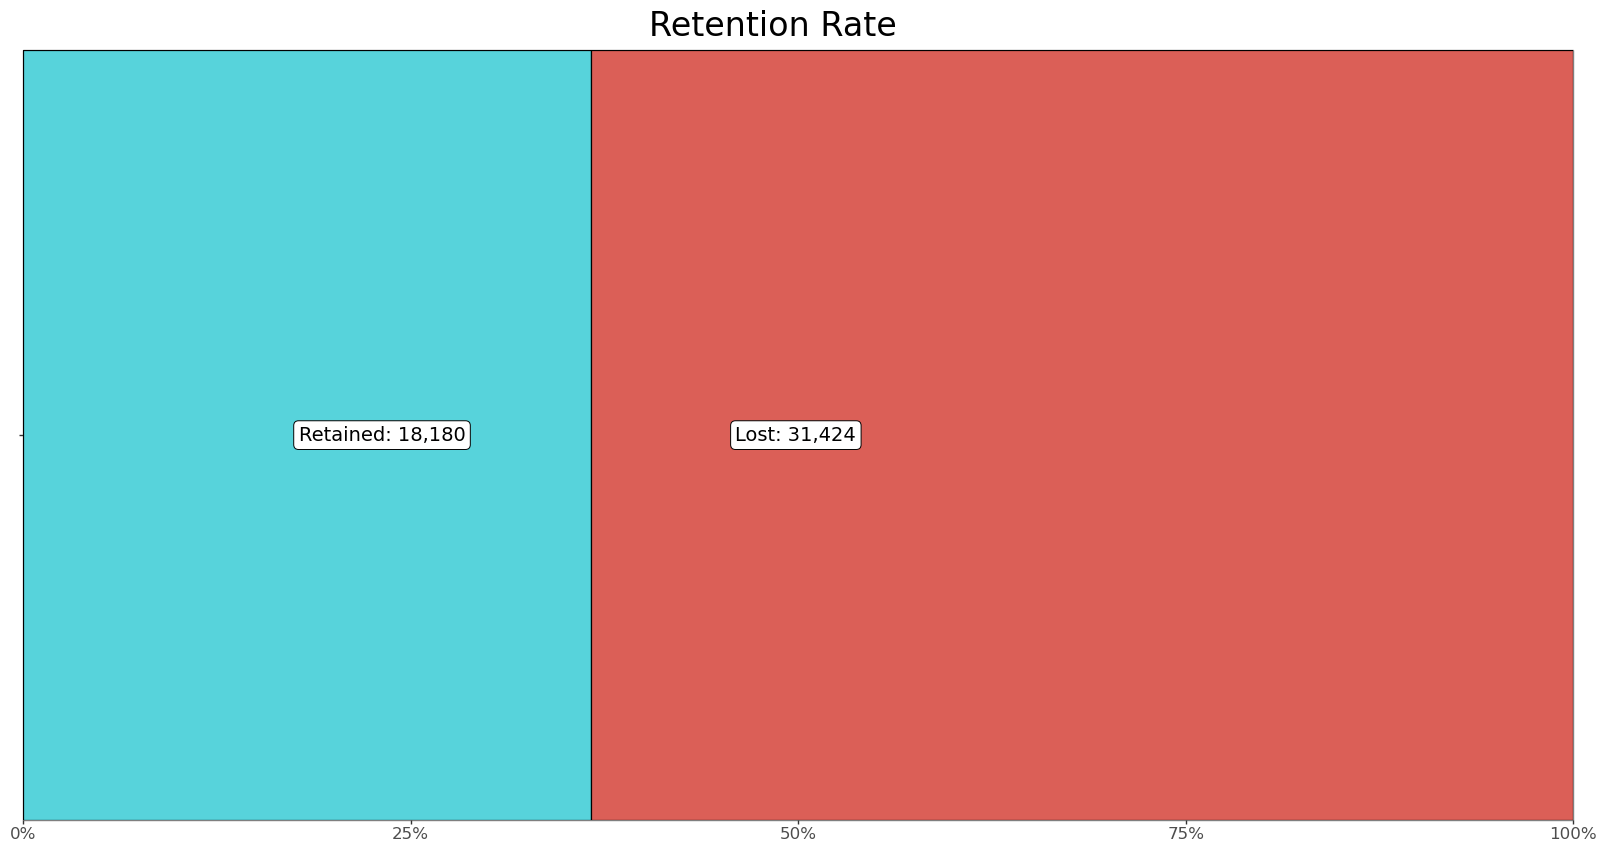

<ggplot: (164177103833)>

In [12]:
retention_df = pd.DataFrame({"user_group": "january_signups",
                     "retention": ["lost", "retained"], 
                     "user_count": df.retention.value_counts()}).\
assign(user_count_label = lambda x: (x.retention.str.title() + ": " + comma_format()(x.user_count)), 
      user_count = lambda x: x.user_count/x.user_count.sum())

(ggplot(retention_df, aes(x = "user_group", y = "user_count", fill = "retention", label = "user_count_label")) + 
 geom_bar(stat = "identity", color = "black", width = 1) + 
 geom_label(fill = "white", size = 14, nudge_y = -.135) + 
 scale_x_discrete(expand = [0,  0]) + 
 scale_y_continuous(labels = percent_format(), expand = [0, 0]) +
 coord_flip() + 
    #expand_limits(x= [0, 5])+ 
 labs(title = "Retention Rate", 
      x = "", 
      y = "") + 
 theme_bw() + 
 theme(legend_position = "none", 
       axis_text_x = element_text(size = 12), 
      axis_text_y = element_blank(), 
      plot_title = element_text(size = 24)))

The dataset shows 37% of users were retained while the remaining 63% were lost

# Preprocessing

I'm changing the retenetion variable to show labels **retained/lost** for readability

In [13]:
df = df.assign(retention = lambda x: x.retention.apply(lambda y: "retained" if y == 1 else "lost"))

## Training & Test Set Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ["retention", "signup_date", "last_trip_date"]), df.retention, 
                                                    test_size = 0.3, random_state = 610)

##  Scaling Inputs

In [15]:
X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(StandardScaler().fit_transform(X_test), columns = X_test.columns)

In [16]:
X_train_scaled.info(verbose = True)
print("=====================================================")
y_train.info(verbose = True)
print("=====================================================")
X_test_scaled.info(verbose = True)
print("=====================================================")
y_test.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34722 entries, 0 to 34721
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  34722 non-null  float64
 1   avg_rating_of_driver    34722 non-null  float64
 2   avg_surge               34722 non-null  float64
 3   surge_pct               34722 non-null  float64
 4   ultimate_black_user     34722 non-null  float64
 5   weekday_pct             34722 non-null  float64
 6   avg_dist                34722 non-null  float64
 7   avg_rating_by_driver    34722 non-null  float64
 8   city_King's Landing     34722 non-null  float64
 9   city_Winterfell         34722 non-null  float64
 10  phone_iPhone            34722 non-null  float64
dtypes: float64(11)
memory usage: 2.9 MB
<class 'pandas.core.series.Series'>
Int64Index: 34722 entries, 39711 to 29147
Series name: retention
Non-Null Count  Dtype 
--------------  ----- 
34722 non-null

# Modeling

The output for this scenario, retention, is dichotmous (retained | lost). With this, I am limited to only using classification models. I will try
* Logistic Regression
* Decision Tree
* random Forest
* K-Nearest Neighbors

## Logistic Regrression

### Hyperparameter Tuning

In [17]:
log_reg = LogisticRegression(random_state = 610)
param_grid = {"solver": ["liblinear", "sag", "saga"], 
              "C": np.arange(0.5, 5.1, 0.1), 
              "max_iter": np.arange(100, 600, 100)}
grid = GridSearchCV(log_reg, param_grid, cv = 5)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=610),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
                         'max_iter': array([100, 200, 300, 400, 500]),
                         'solver': ['liblinear', 'sag', 'saga']})

### Model Creation

In [18]:
log_reg = LogisticRegression(solver = grid.best_estimator_.solver, 
                             max_iter = grid.best_estimator_.max_iter, 
                             C = grid.best_estimator_.C, 
                             random_state = 610)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=0.7, random_state=610, solver='liblinear')

### Model Evaluation

In [19]:
cv = KFold(n_splits = 10, random_state = 610, shuffle = True)
scores = cross_val_score(log_reg, X_train_scaled, y_train, cv = cv)
print("Cross Validation Mean Score: ", round(np.mean(scores), 4), " (Std: ", round(np.std(scores), 4), ")", sep = "")
print("Classification Report for Test Data")
print(classification_report(y_test, log_reg.predict(X_test_scaled)))

Cross Validation Mean Score: 0.726 (Std: 0.0058)
Classification Report for Test Data
              precision    recall  f1-score   support

        lost       0.75      0.85      0.80      9503
    retained       0.65      0.49      0.56      5379

    accuracy                           0.72     14882
   macro avg       0.70      0.67      0.68     14882
weighted avg       0.71      0.72      0.71     14882



In [20]:
evaluation_metrics = pd.array(["model", "train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"])

log_reg_evaluation = pd.array(["Logistic Regression", 
                               round(np.mean(scores), 4), 
                               round(np.std(scores), 4), 
                               round(accuracy_score(log_reg.predict(X_test_scaled), y_test), 4), 
                               round(precision_score(log_reg.predict(X_test_scaled), y_test, pos_label = "retained"), 4), 
                               round(recall_score(log_reg.predict(X_test_scaled), y_test, pos_label = "retained"), 4), 
                               round(f1_score(log_reg.predict(X_test_scaled), y_test, pos_label = "retained"), 4)])

log_reg_evaluation = pd.DataFrame(log_reg_evaluation, evaluation_metrics).transpose()
log_reg_evaluation

,model,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,Logistic Regression,0.726,0.0058,0.7223,0.4914,0.6544,0.5613


## Decision Tree

### Hyperparameter Tuning

In [21]:
dec_tree = DecisionTreeClassifier(random_state = 610)

param_grid = {"criterion": ["gini", "entropy", "log_loss"], 
              "max_depth": np.append(np.arange(10, 110, 10), None)}

grid = GridSearchCV(dec_tree, param_grid, cv = 5)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=610),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], dtype=object)})

### Model Creation

In [22]:
dec_tree = DecisionTreeClassifier(criterion = grid.best_estimator_.criterion, 
                                  max_depth = grid.best_estimator_.max_depth, 
                                  random_state = 610)
dec_tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=10, random_state=610)

### Model Evaluation

In [23]:
cv = KFold(n_splits = 10, random_state = 610, shuffle = True)
scores = cross_val_score(dec_tree, X_train_scaled, y_train, cv = cv)
print("Cross Validation Mean Score: ", round(np.mean(scores), 4), " (Std: ", round(np.std(scores), 4), ")", sep = "")
print("Classification Report for Test Data")
print(classification_report(y_test, dec_tree.predict(X_test_scaled)))

Cross Validation Mean Score: 0.7741 (Std: 0.0048)
Classification Report for Test Data
              precision    recall  f1-score   support

        lost       0.81      0.83      0.82      9503
    retained       0.69      0.65      0.67      5379

    accuracy                           0.77     14882
   macro avg       0.75      0.74      0.74     14882
weighted avg       0.76      0.77      0.77     14882



In [24]:
evaluation_metrics = pd.array(["model", "train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"])

dec_tree_evaluation = pd.array(["Decision Tree", 
                               round(np.mean(scores), 4), 
                               round(np.std(scores), 4), 
                               round(accuracy_score(dec_tree.predict(X_test_scaled), y_test), 4), 
                               round(precision_score(dec_tree.predict(X_test_scaled), y_test, pos_label = "retained"), 4), 
                               round(recall_score(dec_tree.predict(X_test_scaled), y_test, pos_label = "retained"), 4), 
                               round(f1_score(dec_tree.predict(X_test_scaled), y_test, pos_label = "retained"), 4)])

dec_tree_evaluation = pd.DataFrame(dec_tree_evaluation, evaluation_metrics).transpose()
dec_tree_evaluation

,model,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,Decision Tree,0.7741,0.0048,0.7668,0.6538,0.6861,0.6696


## Random Forest

### Hyperparameter Tuning

In [25]:
rand_for = RandomForestClassifier(n_jobs = -1, random_state = 610)

param_grid = {"n_estimators": np.arange(100, 600, 100), 
              #"criterion": ["gini", "entropy", "log_loss"],
              "criterion": ["gini"],
              "max_depth": [5, 10, 20, None],
              "bootstrap": [True, False]}

grid = GridSearchCV(rand_for, param_grid, cv = 5)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=610),
             param_grid={'bootstrap': [True, False], 'criterion': ['gini'],
                         'max_depth': [5, 10, 20, None],
                         'n_estimators': array([100, 200, 300, 400, 500])})

### Model Creation

In [26]:
rand_for = RandomForestClassifier(n_estimators = grid.best_estimator_.n_estimators,
                                  criterion = grid.best_estimator_.criterion,
                                  max_depth = grid.best_estimator_.max_depth, 
                                  bootstrap = grid.best_estimator_.bootstrap, 
                                  n_jobs = -1, 
                                  random_state = 610)

rand_for.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, n_estimators=400, n_jobs=-1,
                       random_state=610)

### Model Evaluation

In [27]:
cv = KFold(n_splits = 10, random_state = 610, shuffle = True)
scores = cross_val_score(rand_for, X_train_scaled, y_train, cv = cv)
print("Cross Validation Mean Score: ", round(np.mean(scores), 4), " (Std: ", round(np.std(scores), 4), ")", sep = "")
print("Classification Report for Test Data")
print(classification_report(y_test, rand_for.predict(X_test_scaled)))

Cross Validation Mean Score: 0.7913 (Std: 0.0066)
Classification Report for Test Data
              precision    recall  f1-score   support

        lost       0.81      0.85      0.83      9503
    retained       0.71      0.65      0.68      5379

    accuracy                           0.78     14882
   macro avg       0.76      0.75      0.76     14882
weighted avg       0.78      0.78      0.78     14882



In [28]:
evaluation_metrics = pd.array(["model", "train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"])

rand_for_evaluation = pd.array(["Random Forest", 
                               round(np.mean(scores), 4), 
                               round(np.std(scores), 4), 
                               round(accuracy_score(rand_for.predict(X_test_scaled), y_test), 4), 
                               round(precision_score(rand_for.predict(X_test_scaled), y_test, pos_label = "retained"), 4), 
                               round(recall_score(rand_for.predict(X_test_scaled), y_test, pos_label = "retained"), 4), 
                               round(f1_score(rand_for.predict(X_test_scaled), y_test, pos_label = "retained"), 4)])

rand_for_evaluation = pd.DataFrame(rand_for_evaluation, evaluation_metrics).transpose()
rand_for_evaluation

,model,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,Random Forest,0.7913,0.0066,0.7793,0.6507,0.7134,0.6806


## KNN

### Hyperparameter Tuning

In [29]:
knn = KNeighborsClassifier()

param_grid = {"n_neighbors": np.arange(1, 20)}

grid = GridSearchCV(knn, param_grid, cv = 5)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

### Model Creation

In [30]:
knn = KNeighborsClassifier(n_neighbors = grid.best_estimator_.n_neighbors)

knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=19)

### Model Evaluation

In [31]:
cv = KFold(n_splits = 10, random_state = 610, shuffle = True)
scores = cross_val_score(knn, X_train_scaled, y_train, cv = cv)
print("Cross Validation Mean Score: ", round(np.mean(scores), 4), " (Std: ", round(np.std(scores), 4), ")", sep = "")
print("Classification Report for Test Data")
print(classification_report(y_test, knn.predict(X_test_scaled)))

Cross Validation Mean Score: 0.768 (Std: 0.0058)
Classification Report for Test Data
              precision    recall  f1-score   support

        lost       0.80      0.83      0.82      9503
    retained       0.68      0.63      0.66      5379

    accuracy                           0.76     14882
   macro avg       0.74      0.73      0.74     14882
weighted avg       0.76      0.76      0.76     14882



In [32]:
evaluation_metrics = pd.array(["model", "train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"])

knn_evaluation = pd.array(["K-Nearest Neighbors", 
                           round(np.mean(scores), 4), 
                           round(np.std(scores), 4), 
                           round(accuracy_score(knn.predict(X_test_scaled), y_test), 4), 
                           round(precision_score(knn.predict(X_test_scaled), y_test, pos_label = "retained"), 4), 
                           round(recall_score(knn.predict(X_test_scaled), y_test, pos_label = "retained"), 4), 
                           round(f1_score(knn.predict(X_test_scaled), y_test, pos_label = "retained"), 4)])

knn_evaluation = pd.DataFrame(knn_evaluation, evaluation_metrics).transpose()
knn_evaluation

,model,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,K-Nearest Neighbors,0.768,0.0058,0.7597,0.6325,0.6803,0.6555


# Model Comparison

## Accuracy Metrics

In [33]:
evaluation_df = pd.concat([log_reg_evaluation, dec_tree_evaluation, rand_for_evaluation, knn_evaluation]).\
                set_index("model").\
                sort_values("accuracy", ascending = False)

evaluation_df

,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
model,,,,,,
Random Forest,0.7913,0.0066,0.7793,0.6507,0.7134,0.6806
Decision Tree,0.7741,0.0048,0.7668,0.6538,0.6861,0.6696
K-Nearest Neighbors,0.768,0.0058,0.7597,0.6325,0.6803,0.6555
Logistic Regression,0.726,0.0058,0.7223,0.4914,0.6544,0.5613


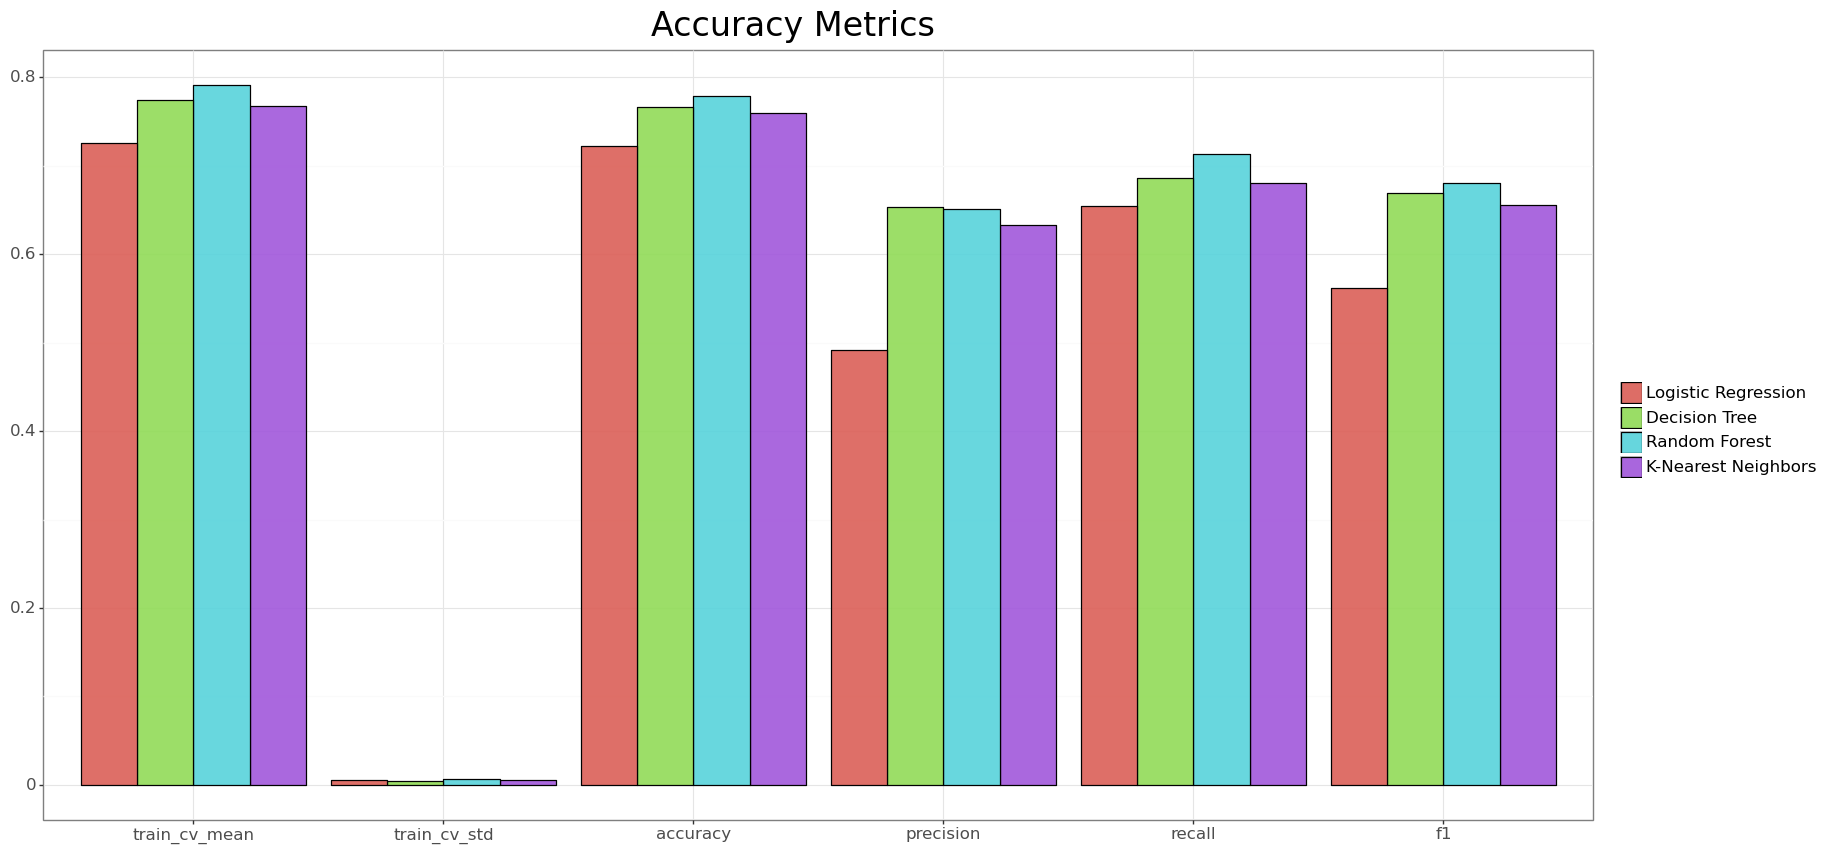

<ggplot: (164178217147)>

In [34]:
evaluation_df2 = evaluation_df.reset_index().\
rename(columns = {"index": "model"}).\
melt(id_vars = ["model"], 
     value_vars = ["train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"], 
     var_name = "metric", 
     value_name = "score").\
assign(model = lambda x: x.model.astype("category").cat.reorder_categories(["Logistic Regression", "Decision Tree", 
                                                                            "Random Forest", "K-Nearest Neighbors"]), 
       metric = lambda x: x.metric.astype("category").cat.reorder_categories(["train_cv_mean", "train_cv_std", "accuracy", 
                                                                              "precision", "recall", "f1"]), 
       score = lambda x: x.score.astype(float))

(ggplot(evaluation_df2, aes(x = "metric", y = "score", fill = "model")) + 
 geom_bar(stat = "identity", position = "dodge", color = "black", alpha = 0.9) + 
 scale_y_continuous() + 
 labs(title = "Accuracy Metrics", 
      x = "", 
      y = "") + 
 theme_bw() +
 theme(axis_text = element_text(size = 12), 
       legend_position = "right",
       legend_text = element_text(size = 12),
       legend_title = element_blank(), 
       plot_title = element_text(size = 24)))

* **Accuracy:** Percent of correctly predicted classes
* **Precision:** TP / (TP + FN)
* **Recall:** TP / (TP + FN)
* **F1:** 2 * (Precision * Recall) / (Precision + Recall)

Random Forest is the clear winner as it is the most accurate, has the best recall, and F1 score. It barely lost out to the single Decision Tree in precision though.

Logistic regression lagged behind the other models be a noticible margin in every metric

## Precision/Recall Curve

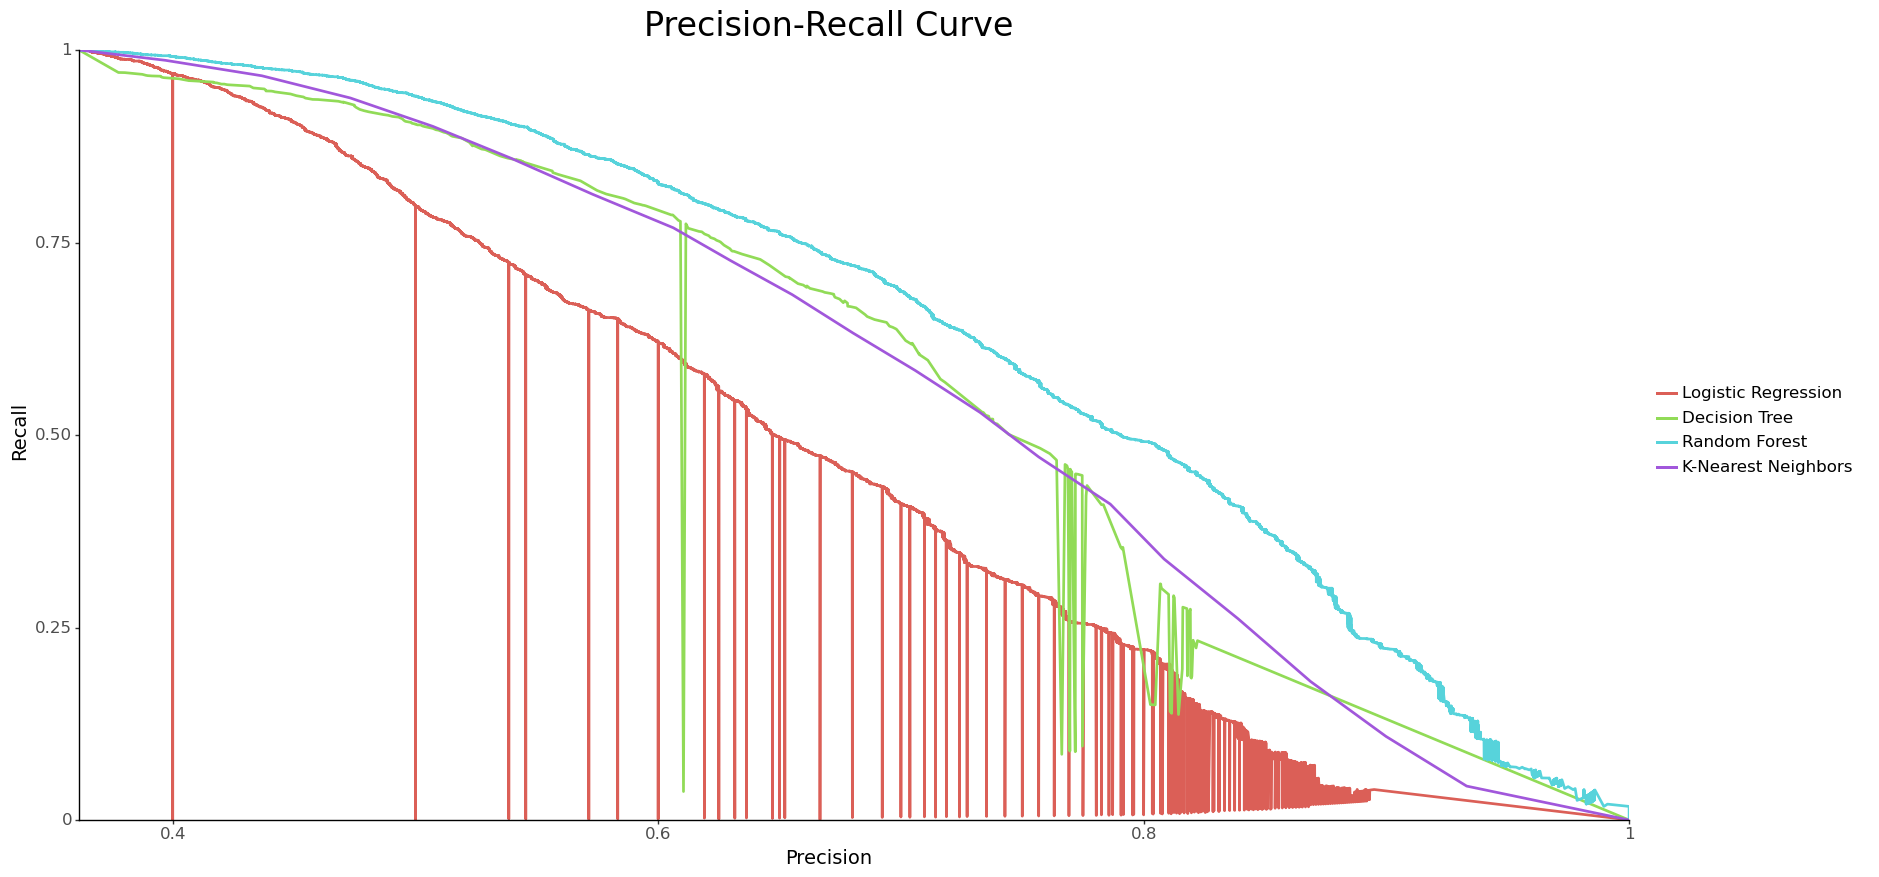

<ggplot: (164177177092)>

In [35]:
model_names = ["Logistic Regression", 
               "Decision Tree", 
               "Random Forest", 
               "K-Nearest Neighbors"]

predicted_probs = [log_reg.predict_proba(X_test_scaled)[:, 1],
                   dec_tree.predict_proba(X_test_scaled)[:, 1],
                   rand_for.predict_proba(X_test_scaled)[:, 1],
                   knn.predict_proba(X_test_scaled)[:, 1]]

pr_df = pd.DataFrame({"model": [], 
                      "precision" : [], 
                      "recall" : [],
                      "thresholds" : []})

for i in range(len(model_names)): 
    
    precision, recall, thresholds  = precision_recall_curve(y_test, predicted_probs[i], pos_label = "retained")
    
    thresholds = np.append(thresholds, 0)
    
    pr_append_df = pd.DataFrame({"model": model_names[i], 
                                 "precision":precision, 
                                 "recall":recall, 
                                 "thresholds":thresholds})
    
    pr_df = pr_df.append(pr_append_df)
    
pr_df = pr_df.\
assign(model = lambda x: x.model.astype("category").cat.reorder_categories(["Logistic Regression", 
                                                                            "Decision Tree", 
                                                                            "Random Forest", 
                                                                            "K-Nearest Neighbors"]))

(ggplot(pr_df, aes(x = "precision", y = "recall", color = "model")) + 
 geom_line(size = 1.1) + 
 scale_x_continuous(expand = [0, 0]) + 
 scale_y_continuous(expand = [0, 0]) + 
 labs(title = "Precision-Recall Curve", 
      x = "Precision", 
      y = "Recall") + 
 theme_classic() +
 theme(axis_text = element_text(size = 12), 
       axis_title = element_text(size = 14),
       legend_position = "right",
       legend_text = element_text(size = 12),
       legend_title = element_blank(), 
       plot_title = element_text(size = 24)))

The strange looking verticle lines are due to rounding. The scores round to 4 digits so the dataframe will show duplicate Precision values with differeing Recall values. The picture however is still visible and the AUC is still able to be calculated.

That being said, Random Forest wins by  long shot while Logistic Regression once again lags behind.

## ROC Curve

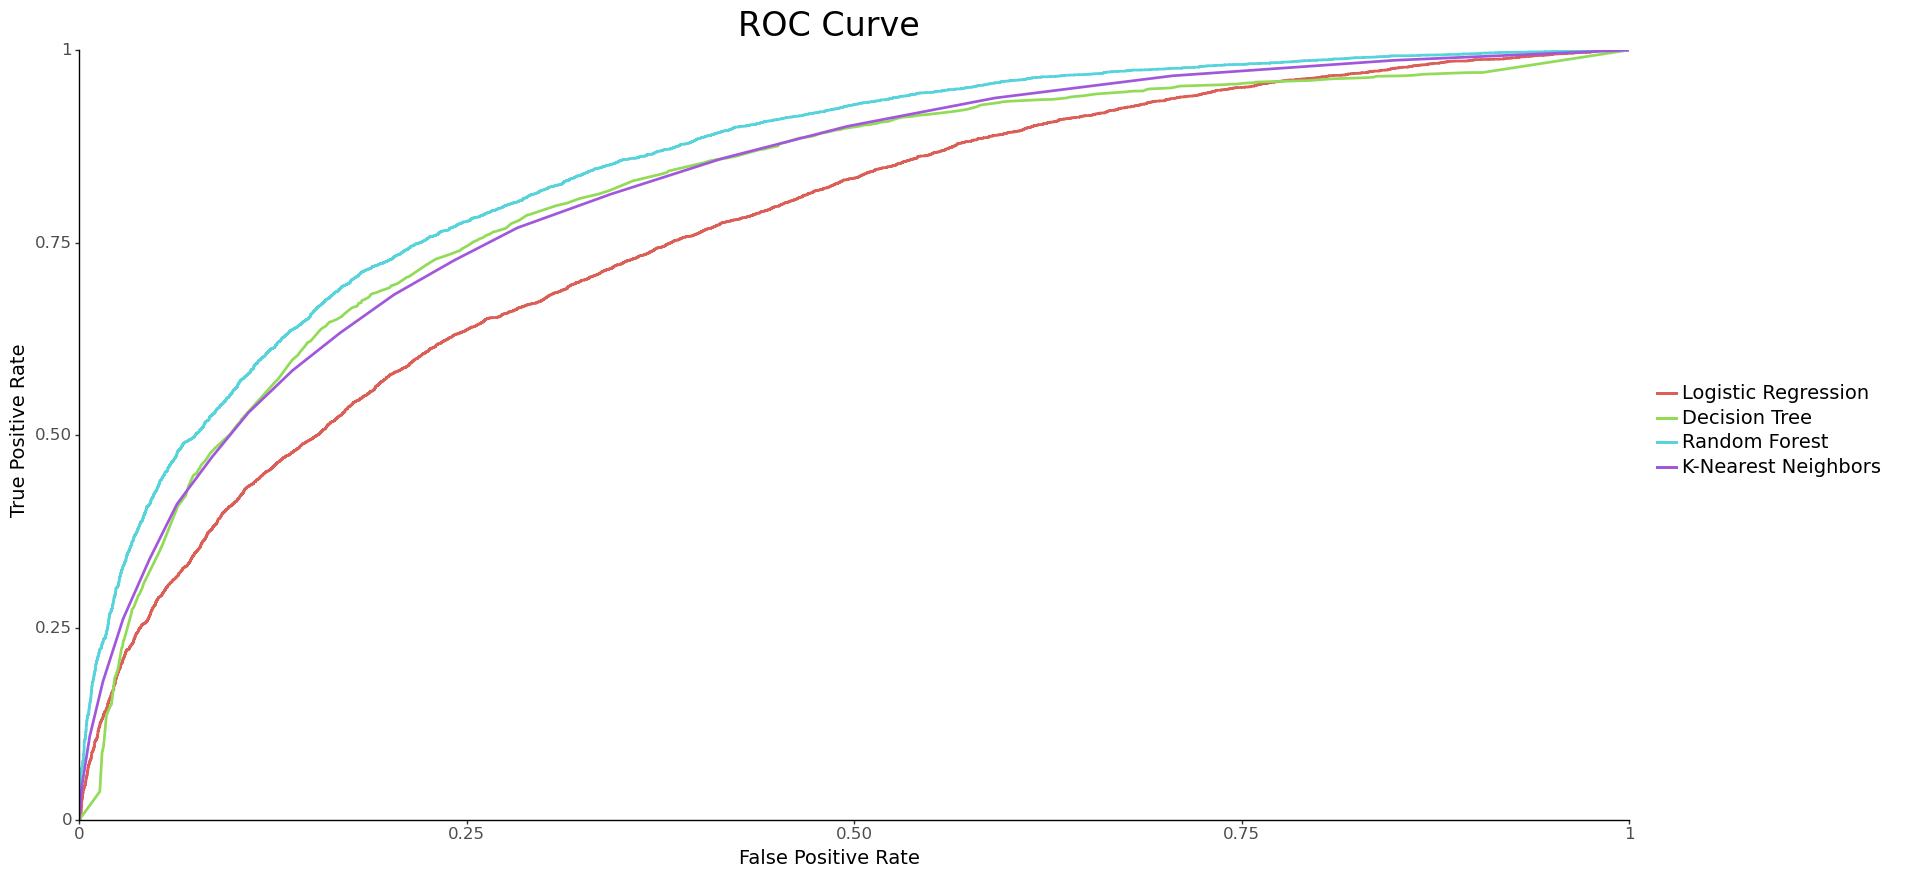

<ggplot: (164176304463)>

In [36]:
model_names = ["Logistic Regression", 
               "Decision Tree", 
               "Random Forest", 
               "K-Nearest Neighbors"]

predicted_probs = [log_reg.predict_proba(X_test_scaled)[:, 1],
                   dec_tree.predict_proba(X_test_scaled)[:, 1],
                   rand_for.predict_proba(X_test_scaled)[:, 1],
                   knn.predict_proba(X_test_scaled)[:, 1]]

roc_df = pd.DataFrame({"model": [], 
                       "fpr" : [], 
                       "tpr" : [],
                       "thresholds" : []})

for i in range(len(model_names)): 
    
    fpr, tpr, thresholds  = roc_curve(y_test, predicted_probs[i], pos_label = "retained")
    
    roc_append_df = pd.DataFrame({"model": model_names[i],
                                  "auc": round(auc(fpr, tpr), 3).astype(str),
                                  "fpr":fpr, 
                                  "tpr":tpr, 
                                  "thresholds":thresholds})
    
    roc_df = roc_df.append(roc_append_df)

roc_df = roc_df.\
assign(model = lambda x: x.model.astype("category").cat.reorder_categories(["Logistic Regression", 
                                                                            "Decision Tree", 
                                                                            "Random Forest", 
                                                                            "K-Nearest Neighbors"]))

(ggplot(roc_df, aes(x = "fpr", y = "tpr", color = "model")) + 
 geom_line(size = 1.1) + 
 scale_x_continuous(expand = [0, 0]) + 
 scale_y_continuous(expand = [0, 0]) + 
 labs(title = "ROC Curve", 
      x = "False Positive Rate", 
      y = "True Positive Rate") + 
 theme_classic() +
 theme(axis_text = element_text(size = 12), 
       axis_title = element_text(size = 14), 
       legend_position = "right",
       legend_text = element_text(size = 14),
       legend_title = element_blank(), 
       plot_title = element_text(size = 24)))

The ROC curve shows the same findings the other tests showed. Random Forest performs the best while Logistic Regression lags behind.

## Feature Importance

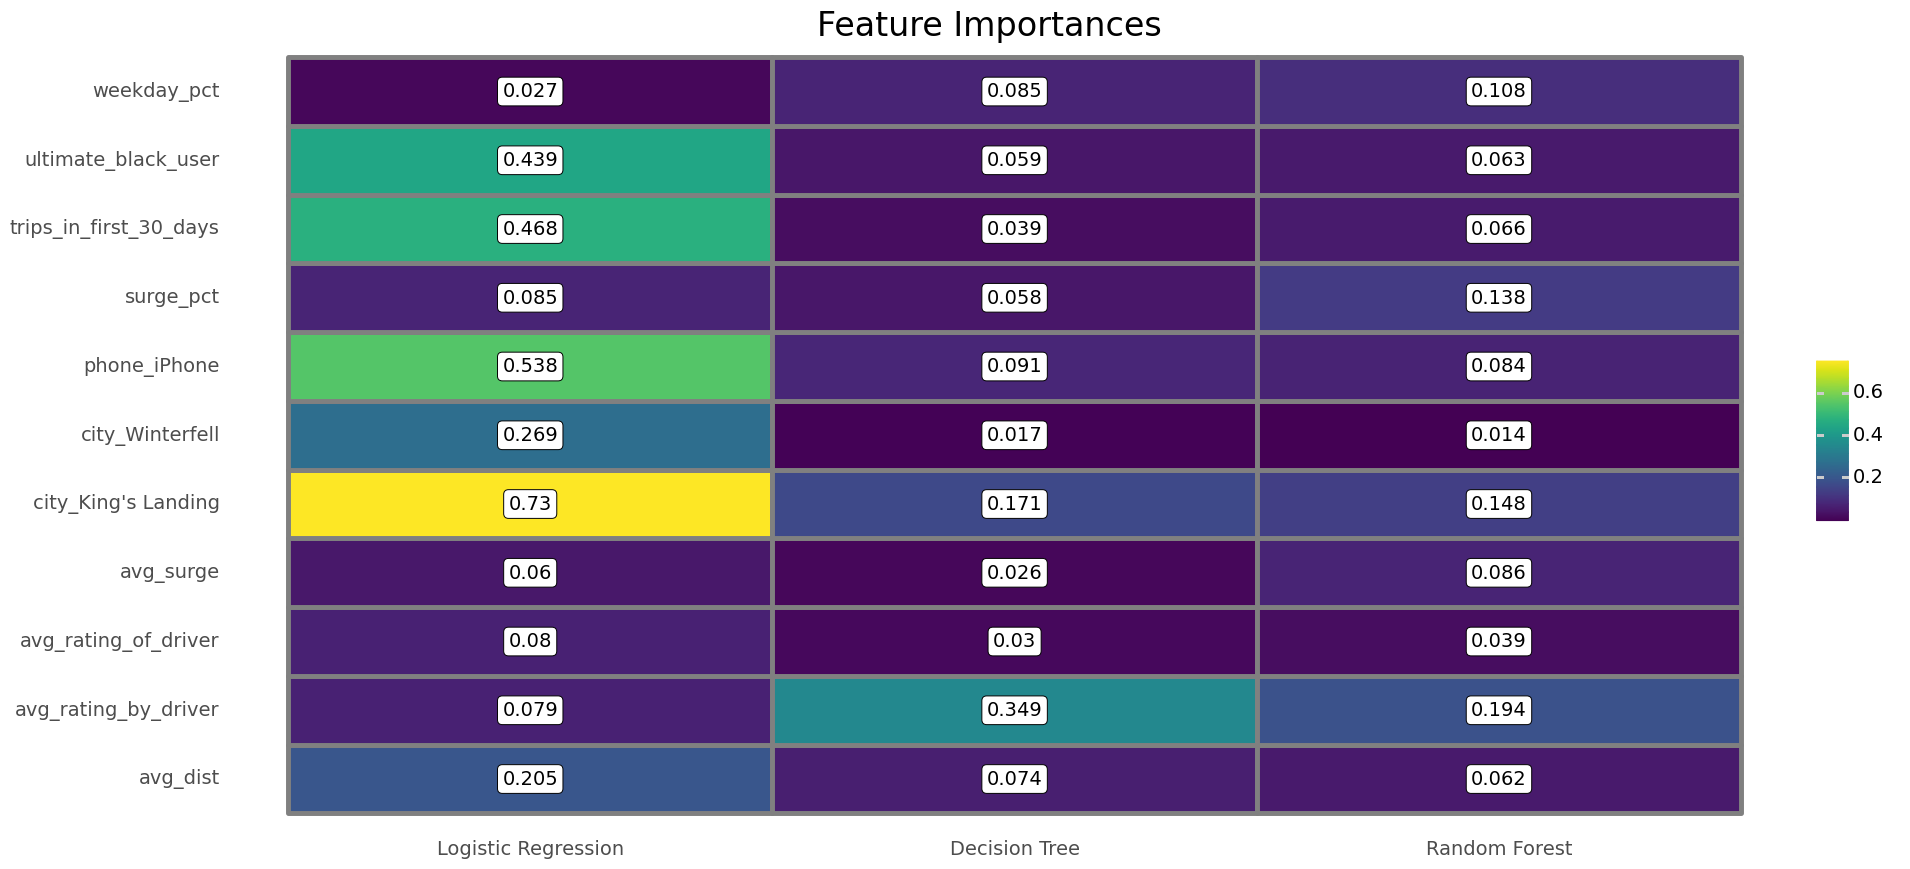

<ggplot: (164176294985)>

In [37]:
feature_list_df = pd.DataFrame({"Logistic Regression" : np.abs(np.std(X_train_scaled) * log_reg.coef_[0]).sort_values(ascending = False), 
                                "Decision Tree" : pd.Series(dec_tree.feature_importances_, index = dec_tree.feature_names_in_).sort_values(ascending = False),
                                "Random Forest" : pd.Series(rand_for.feature_importances_, index = rand_for.feature_names_in_).sort_values(ascending = False)}).reset_index().\
rename(columns = {"index" : "feature"}).\
melt(id_vars = ["feature"], 
     value_vars = ["Logistic Regression", "Decision Tree", "Random Forest"], 
     var_name = "model", 
     value_name = "importance").\
assign(lab_text = lambda x: np.round(x.importance, 3), 
       model = lambda x: x.model.astype("category").cat.reorder_categories(["Logistic Regression", 
                                                                            "Decision Tree", 
                                                                            "Random Forest"]))

(ggplot(feature_list_df, aes(x = "model", y = "feature", fill = "importance")) + 
 geom_tile(color = "grey", size = 2) +
 geom_label(aes(label = "lab_text"), fill = "white", size = 14) + 
 labs(title = "Feature Importances", 
      x = "", 
      y = "", 
      fill = "") + 
 theme_minimal() + 
 theme(axis_text_x = element_text(size = 14), 
       axis_text_y = element_text(size = 14), 
       legend_text = element_text(size = 14),
       panel_grid_major = element_blank(), 
       plot_title = element_text(size = 24)))

Note K-Nearest Neighbors does not have feature improtance. Logisitc Regression require a manual calculation as it lacks the **feature_importances_** attribute found in Decision Tree and Random Forest.

At this point, the only model that really matters here is Random Forest. However it is interesting to see Logistic Regression having so many highly importance variables. It's possible my calculation differs from the one used in the feature **feature_importances_** attribute found in the other models.

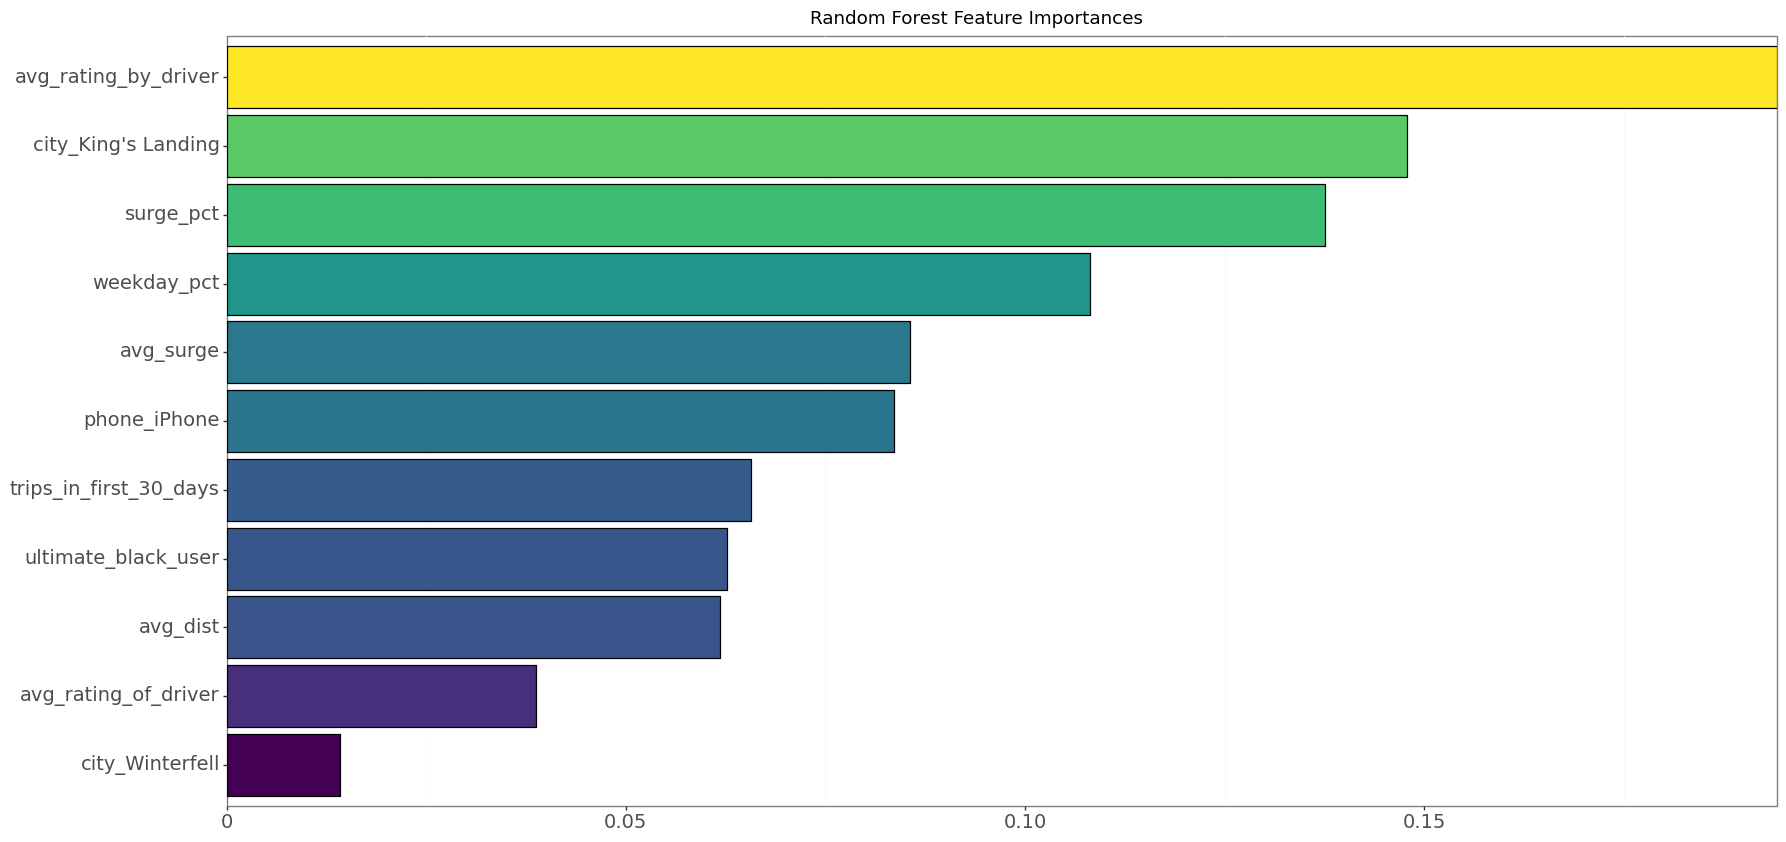

<ggplot: (164178961902)>

In [38]:
rand_for_features_df = pd.DataFrame({"importance": pd.Series(rand_for.feature_importances_, index = rand_for.feature_names_in_)}).\
reset_index().\
rename(columns = {"index" : "feature"}).\
assign(feature = lambda x: x.feature.astype("category").cat.reorder_categories(x.set_index("feature").sort_values("importance").index.tolist()))


(ggplot(rand_for_features_df, aes(x = "feature", y = "importance", fill = "importance")) + 
 geom_bar(stat = "identity", color = "black") + 
 coord_flip() + 
 scale_y_continuous(expand = [0, 0])+ 
 labs(title = "Random Forest Feature Importances", 
      x = "", 
      y = "", 
      fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 14), 
       axis_text_y = element_text(size = 14), 
       legend_position = "none",
       panel_grid_major = element_blank()))

Top features are **avg_rating_by_driver**, **city_Kings's Landing**, **surge_pct**, and **weekday_pct**

## Best model

As stated above, the best model is easily Random Forest. It's only drawback is that the runtime is a bit longer than the other models, especially when running multiple times through cross-validation, but it's well worth the increased accuracy.

In [39]:
rand_for_evaluation

,model,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,Random Forest,0.7913,0.0066,0.7793,0.6507,0.7134,0.6806


# Business Apllication

Again, the top features are **avg_rating_by_driver**, **city_Kings's Landing**, **surge_pct**, and **weekday_pct**. So let's look at them one by one

In [40]:
rf_list = rand_for_features_df.sort_values("feature", ascending = False)[0:4].feature.to_list()

df_corr.query("var2 in @rf_list & var1 == 'retention'").\
filter(items = ["var2", "value"]).\
rename(columns = {"var2": "feature", "value": "correlation"}).\
set_index("feature").\
join(rand_for_features_df.sort_values("feature", ascending = False)[0:4].set_index("feature"), on = "feature", how = "inner").\
sort_values("importance", ascending = False)

,correlation,importance
feature,,
avg_rating_by_driver,-0.025916,0.194157
city_King's Landing,0.268372,0.147899
surge_pct,0.010058,0.137529
weekday_pct,0.026395,0.108169


* **avg_rating_by_driver:** This one is a little odd because it's the average rating BY the driver. So it's the rating the driver gave to the rider. What's also notable is the correlation to retention is almost 0 and in fact, slightly negative. I'm honestly not sure what to make of this.
* **city_King's Landing:** This is the dummy variable for City. considering how **city_Winterfell** was the least important, this tells me that whether or not users signed up in  King's Landing is important. The correlation is a positive 0.26 which tells me that users in King's Landing are more likely to be retained. Maybe it has something to do with the layout of that city in comparison to the others. Are there other cities that have noticeably higher retention rates? Further research would need to be done to figure out what aspects of certain cities lead to better retention.
* **surge_pct:** I don't know what the surge multiplier does exactly. I don't know if this is association or causation either. Is it that users who take advantage of the surge multiplier are more likely to be retained or that the surge multiplier helps keep users retained. In a real world scenario, I'd talk with someone in the product team for more details.
* **weekday_pct:** This tells me that users who take more of their trips during weekdays have higher retention. My guess is that these are users who are taking rides to work which is needed while weekend trips tend to be voluntary. Maybe they should implement some discount or rewards program for users taking trips on weekdays